# Basic Bitcoin Analysis with Julia

##### Author: Isaac Lee
##### Date: 13/02/2022
-------------------------------

## Project Planning

### Interesting Questions
#### 1. Volume
- 1.1: What is the hourly volume change (get data)?
- 1.2: Does the volume have any affect on the close price?
#### 2. Volatility
- 2.1: What is the volatility per hours of day (get data)?
- 2.2 Is there a correlation between volatility and volume change?

------------
## Packages

In [31]:
# Global Variables

# IJulia Parameters
IJulia.set_max_stdio(1 << 20) # Give more memory to stdout
ENV["COLUMNS"] = 1000
ENV["LINES"] = 20
ENV["JULIA_NUM_THREADS"] = 4
ENV["PYTHON"] = "/home/isaac/.virtualenvs/ml_env/bin/python3"

# Plot color variables
global color1 = "#6CB190"
global color2 = "#1D2562"
global color3 = "#ace5ee"
global my_blue = "#94c6da"
global my_red = "#c30d24"
global my_creme = "#f3a583"
global my_gray = "#cccccc"

"#cccccc"

In [32]:
# Note: This will take a long time to first run, so I have compiled my own kernel to 
# make this a lot faster.
begin
    # Requests
    using HTTP 
    using JSON
    # Data
    using CSV
    using DataFrames
    using Dates
    using TimeSeries
    # Maths
    using LinearAlgebra
    using Statistics
    # Plotting
    using VegaLite
    using Plots
    default(fmt = :png)
    # Other language wrappers
    using RCall
    using PyCall
    using Images  # This takes a long time to precompile
    using FileIO
end

------------
## Custom Wrapper Functions

In [33]:
# Print the response string with nice indentation
function pprint(response::AbstractDict, indent::Int64=4)
    print(json(response, indent))
    return nothing
end


# If we get an error
function pprint(response::String, indent=4::Int64)
    print(response)
    return nothing
end


function get_request(url::String, params::Dict)
    try
        response = HTTP.get(url, query=params)
        return JSON.parse(String(response.body))
    catch e
        return "Error occurred : $e"
    end
end

get_request (generic function with 1 method)

------------
## Getting Data
https://docs.poloniex.com/#returnchartdata  
https://www.unixtimestamp.com/

Getting price and volume data for the past five years, using the Poloneix api:

In [34]:
curr_pair = "USDT_BTC"

"USDT_BTC"

In [35]:
base_url = "https://poloniex.com/public"
# Define a an array of arrays, with each sub-array corresponding to the start and end unix time stamp of the year,
# starting from 2017.
years = [[1483228800, 1514678400], [1514764800, 1546214400], [1546300800, 1577750400], [1577836800, 1609372800], [1609459200, 1640908800]]
df = DataFrame()
for (idx, year) in enumerate(years)
    println("Getting data for year $(2017 + idx - 1)")
    params = Dict("command"=>"returnChartData",
                "currencyPair"=>curr_pair,	# A string that defines the market, "USDT_BTC" for example.
                "period"=>1800, # Candlestick period in seconds. Valid values are 300, 900, 1800, 7200, 14400, and 86400.
                "start"=>year[1], # The start of the window in seconds since the unix epoch.
                "end"=>year[2]
                )	
    r = get_request(base_url, params)
    # Converting array of dicts to a dataframe and appending
    for i in 1:length(r)
        append!(df, DataFrame(r[i]))
    end
end
println("Parsing Date column:")
DataFrames.rename!(df, Dict(:date => :unix_date))
# Convert unix timestamps to DateTime objects
df.date = Dates.unix2datetime.(df[:, :unix_date])
 # Reorder and remove unwanted cols
select!(df, :date, :weightedAverage, Not([:unix_date, :date, :weightedAverage, :quoteVolume]))
# Print head of df
df[1:5, :]

Getting data for year 2017
Getting data for year 2018
Getting data for year 2019
Getting data for year 2020
Getting data for year 2021
Parsing Date column:


,date,weightedAverage,close,high,low,open,volume
,DateTime,Float64,Float64,Float64,Float64,Float64,Float64
1,2017-01-01T00:00:00,963.754,966.15,966.15,961.7,965.0,11900.7
2,2017-01-01T00:30:00,963.482,964.133,965.668,962.88,962.88,2738.66
3,2017-01-01T01:00:00,965.778,965.855,965.855,964.133,964.133,1032.53
4,2017-01-01T01:30:00,966.424,966.75,967.0,965.0,965.855,8361.22
5,2017-01-01T02:00:00,966.041,963.943,968.0,963.943,967.0,9689.23


In [36]:
# Also examining the tail of the df:
df[end-5:end, :]

,date,weightedAverage,close,high,low,open,volume
,DateTime,Float64,Float64,Float64,Float64,Float64,Float64
1,2021-12-30T21:30:00,47253.5,47295.7,47335.8,47149.0,47305.8,1.22297e5
2,2021-12-30T22:00:00,47248.3,47231.2,47322.6,47125.4,47274.5,3.20326e5
3,2021-12-30T22:30:00,46909.4,47068.1,47231.2,46749.2,47231.2,3.83893e5
4,2021-12-30T23:00:00,47089.9,47144.0,47251.5,47000.9,47078.2,3.58633e5
5,2021-12-30T23:30:00,47094.6,47123.6,47179.3,46945.3,47132.1,66675.7
6,2021-12-31T00:00:00,47243.1,47026.1,47378.4,47000.0,47116.3,3.70225e5


In [37]:
describe(df)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,date,,2017-01-01T00:00:00,,2021-12-31T00:00:00,0,DateTime
2,weightedAverage,15435.8,757.766,8598.81,68584.7,0,Float64
3,close,15437.7,757.0,8600.0,68615.3,0,Float64
4,high,15499.1,765.0,8638.3,69000.0,0,Float64
5,low,15371.8,751.0,8562.37,68463.9,0,Float64
6,open,15437.5,756.77,8599.48,68622.2,0,Float64
7,volume,5.63024e5,0.0,2.57438e5,3.09885e7,0,Float64


### Aggregate 30min candles into 1hr candles
The API we are using doesn't have the option to get 1hr candles, so instead we get 30min candles
and then aggregate the rows to combine into 1hr candles.

In [38]:
if size(df, 1) % 2 == 0
    delete!(df, size(df, 1)) # Delete the last row if even number of rows
end

agg_df = DataFrame(df[1, :])

for i in 2:2:size(df, 1) - 1  # Loop over each row
    r = Dict("date"=>df[i+1, :date], 
             "close"=>df[i+1, :close], 
             "open"=>df[i, :open], 
             "low"=>min(df[i, :low], df[i+1, :low]), 
             "high"=>max(df[i, :high], df[i+1, :high]),
             "weightedAverage"=> mean([df[i, :weightedAverage], df[i+1, :weightedAverage]]),
             "volume"=>df[i, :volume] + df[i+1, :volume]
            )
    append!(agg_df, DataFrame(r))
end

delete!(agg_df, 1) # Delete the first row
df = agg_df # Because I'm lazy
df[1:2, :]


,date,weightedAverage,close,high,low,open,volume
,DateTime,Float64,Float64,Float64,Float64,Float64,Float64
1,2017-01-01T01:00:00,964.63,965.855,965.855,962.88,962.88,3771.19
2,2017-01-01T02:00:00,966.233,963.943,968.0,963.943,965.855,18050.5


### Quick Visualization

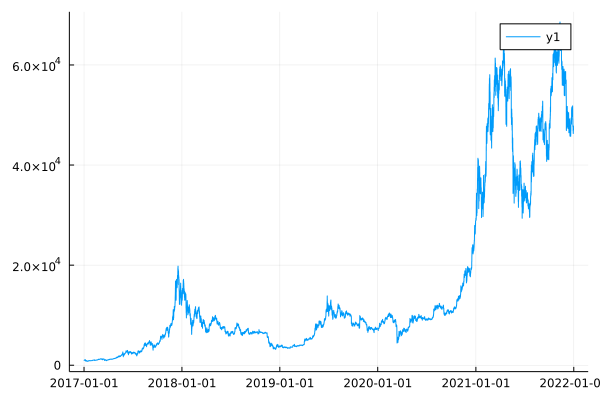

In [39]:
plot(df[:, :date], df[:, :weightedAverage])

### Save as a CSV

In [40]:
# Saving as a CSV
CSV.write("./Data/Price/$(curr_pair)_hourly_candles_2017-2022.csv", df)

"./Data/Price/USDT_BTC_hourly_candles_2017-2022.csv"

------------
## 0. Visualizing _All_ Data

### Plotting Candles
We first look at visualizing *all* of our data.

With an interactive plot...

In [41]:
# Interactive Candles Plot
@pyimport plotly.graph_objects as go # For some reason the native julia plotly library is broken for me
f = go.Figure(data=[go.Candlestick(x=df.date,
                open=df.open,
                high=df.high,
                low=df.low,
                close=df.close)
            ]
        )
f.update_layout(xaxis_rangeslider_visible=false)
f.show()

With a static plot...

In [42]:
fig = df |> @vlplot(height=500, width=1200, title="Price for Entire Time Period") + @vlplot(
    mark={:line, point=false, color=:black}, 
    x={"date:t"},
    y={:open, scale={zero=false}}
    ) + 
    @vlplot(
    mark={:line, point=false, color=my_blue}, 
    x={"date:t"},
    y={:close, scale={zero=false}}
    )

save("price_entire.png", fig)

┌ Warning: Mapping to the storage type failed; perhaps your data had out-of-range values?
│ Try `map(clamp01nan, img)` to clamp values to a valid range.
└ @ ImageMagick /home/isaac/.julia/packages/ImageMagick/Fh2BX/src/ImageMagick.jl:179


## 1. Volume

### 1.1 Volume Data

How does the volume relate to the close/open prices?   
Note: This plot is scaled for readability.

In [43]:
n = 100
open = df[1:n, :open]
close = df[1:n, :close]
vol = df[1:n, :volume]
y₀ = round.(normalize(open .- mean(open)), digits=3)
y₁ = round.(normalize(close .- mean(close)), digits=3)
y₂ = round.(normalize(vol .- mean(vol)), digits=3)
x = df[:, :date][1:n]

fig = @vlplot(
    title="(Scaled) Open Price Vs. Close Price Vs. Volume",
    height=700, 
    width=1300,
    encoding={
        x={axis={labelAngle=70, title="Time", labelOverlap=false}},
        y={axis={labelAngle=0, labelOverlap=true}, scale={reverse=true}}, # For some reason by default the scale goes from positve to negative
        color={
            scale={domain=["Open Price", "Close Price", "Volume"], range=[my_creme, my_red, my_blue]}
        }
    }
) + 
@vlplot(
    mark={:line, point=true},
    encoding={
        x=x,
        y=y₀,
        color={datum="Open Price"}
    } 
) + 
@vlplot(
    mark={:line, point=true},
    encoding={
        x=x,
        y=y₁,
        color={datum="Close Price"}
    } 
) + 
@vlplot(
    mark={:line, point=true},
    encoding={
        x=x,
        y=y₂,
        color={datum="Volume"}
    }
)

save("open_close_vol.png", fig)


┌ Warning: Mapping to the storage type failed; perhaps your data had out-of-range values?
│ Try `map(clamp01nan, img)` to clamp values to a valid range.
└ @ ImageMagick /home/isaac/.julia/packages/ImageMagick/Fh2BX/src/ImageMagick.jl:179


### 1.2 Daily Volume Patterns
Look at volume traded each day for each hour of the day, for all days present in the data.

In [47]:
hrs = unique(hour.(df[:, :date]))
df_by_hrs_dict = Dict("day"=>Array(1.0:size(df[:,:date], 1)/24.0))
for hr in hrs
    df_by_hrs_dict["$hr"] = df[hour.(df[:, :date]) .== hr, :volume]
end

df_by_hrs_dict
# hrs_df = DataFrame(df_by_hrs_dict)
# Re-arrange the columns so we can read easier
# select!(hrs_df, :day, Not(:day))
# hrs_df[1:5, :]

# hrs_df = DataFrames.stack(hrs_df, 2:25)
# DataFrames.rename!(hrs_df, Dict(:variable => :time, :value=>:volume))
# string_to_float(str) = parse(Float64, str)
# hrs_df[!,:time] = parse.(Float64, hrs_df[!,:time]) # Convert from string to float
# sort!(hrs_df, [:day, :time])
# hrs_df[1:5, :]

24-element Array{Int64,1}:
  1
  2
  3
  4
  5
  6
  7
  8
  ⋮
 18
 19
 20
 21
 22
 23
  0

In [ ]:
fig = hrs_df[1:2500, :] |>
@vlplot(
    title="Volume per day for different hours of the day.",
    mark={type=:bar, width=10},
    x=:day,
    y=:volume,
    color=:time,
    width=1300,
    height=600
)
save("volume_per_hour.png", fig)

LoadError: [91mUndefVarError: hrs_df not defined[39m

This is a plot of the volume at different times of the day, for each day in the data, with later times representer by darker colors.

It is clear that earlier in the day the volume traded is greatest and then as it gets later the volume is reduced.

### 1.3 Volume Change Vs. Price Change
Does the percentage change in a candles close price depend on the total volume traded for that hour?

In [ ]:
# Return an array of percent changes of each observation compared to its previous rows value
function relative_percent_change(df::DataFrame, col::Union{String, Symbol})
    function el_perc(a::Union{Float64, Int64}, b::Union{Float64, Int64})
        if b == 0 # Avoid zero division errors
            return 100.0 # Define the percentage change after zero volume to be +100%
        elseif a == 0
            return -100.0
        else
            return ((b - a) / a)  * 100
        end
    end
    curr = df[2:end, col]
    prev = df[1:end-1, col]
    return el_perc.(curr, prev)
end

relative_percent_change (generic function with 1 method)

In [ ]:
close_delta = relative_percent_change(df, :close)
open_delta = relative_percent_change(df, :open)
vol_delta = relative_percent_change(df, :volume)
y₀ = round.(open_delta ./ norm(open_delta), digits=3)
y₁ = round.(close_delta ./ norm(close_delta), digits=3)
y₂ = round.(vol_delta ./ norm(vol_delta), digits=3)
x = df[2:end, :date]

pl_df = DataFrame(Dict("x"=>x, "open_delta"=>y₀, "close_delta"=>y₁, "vol_delta"=>y₂)) # DataFrame used for plotting
pl_df[1:5, :]

,close_delta,open_delta,vol_delta,x
,Float64,Float64,Float64,DateTime
1,0.003,-0.021,0.002,2021-01-01T02:00:00
2,0.003,0.005,0.009,2021-01-01T03:00:00
3,-0.005,0.002,-0.003,2021-01-01T04:00:00
4,0.007,-0.006,0.007,2021-01-01T05:00:00
5,0.002,0.008,0.012,2021-01-01T06:00:00


In [ ]:
fig = pl_df[500:600, :] |> 
@vlplot(
    title="Percent change from previous candle: Close Vs. Volume",
    height=500, 
    width=1200,
    encoding={
        x={axis={labelAngle=60, title="Time"}},
        y={axis={labelAngle=0, labelOverlap=true}},
        color={
            type="nominal",
            scale={domain=["Close Price Percent Change", "Volume Percent Change"], range=[my_blue, my_red]}
        }
    }
) +
@vlplot(
    mark={type=:bar, size=6, fillOpacity=0.5},
    x="x",
    y="close_delta",
    color={datum="Close Price Percent Change"}
) +
#@vlplot(
#    mark={type=:bar, size=6, fillOpacity=0.5},
#    x="x",
#    y="open_delta",
#    color={datum="Open Price Percent Change"}
#) +
@vlplot(
    mark={type=:bar, size=8, fillOpacity=0.5},
    x="x",
    y="vol_delta",
    color={datum="Volume Percent Change"}
)

save("percent_change_close_vol.png", fig)

┌ Warning: Mapping to the storage type failed; perhaps your data had out-of-range values?
│ Try `map(clamp01nan, img)` to clamp values to a valid range.
└ @ ImageMagick /home/isaac/.julia/packages/ImageMagick/Fh2BX/src/ImageMagick.jl:179


This is a plot of the percentage change in volume an close price compared to the previous candle.  
It appears that an increase in volume could possibly be correlated with a decrease in close price. Is the reverse true?  

We can ask the question: given the percentage change in volume is negative/positive, can we determine whether the percentage change in close
will be negative/positive?

In [ ]:
# In this cell we are just making the table.
close_delta = relative_percent_change(df, :close)
open_delta = relative_percent_change(df, :open)
vol_delta = relative_percent_change(df, :volume)

delta_df = DataFrame(Dict("VolDelta"=>vol_delta, "CloseDelta"=>close_delta))

pos_close_and_pos_vol_count = size(filter(row -> row.CloseDelta >= 0 && row.VolDelta >= 0, delta_df), 1)
pos_close_and_neg_vol_count = size(filter(row -> row.CloseDelta >= 0 && row.VolDelta < 0, delta_df), 1)
neg_close_and_pos_vol_count = size(filter(row -> row.CloseDelta < 0 && row.VolDelta >= 0, delta_df), 1)
neg_close_and_neg_vol_count = size(filter(row -> row.CloseDelta < 0 && row.VolDelta < 0, delta_df), 1)

row_idx = ["Negative % Change in Volume", "Positive % Change in Volume"]

# Tabluate findings  
delta_table = DataFrame(Dict(""=>row_idx,
 "Negative % Change in Close"=>[neg_close_and_neg_vol_count, neg_close_and_pos_vol_count],
 "Positive % Change in Close"=>[pos_close_and_neg_vol_count, pos_close_and_pos_vol_count]
))

,,Negative % Change in Close,Positive % Change in Close
,String,Int64,Int64
1,Negative % Change in Volume,2365,2390
2,Positive % Change in Volume,2630,2454


So clearly they are actually about equally distributed, suggesting that this is perhaps a dead end and for hourly candles.  
However from the above plot, maybe if we only count very large volume changes we will see a correlation?

In [ ]:
threshold = 80.0
sig_df = delta_df[abs.(delta_df[:, :VolDelta]) .> threshold, :] # Significant values dataframe

pos_close_and_pos_vol_count = size(filter(row -> row.CloseDelta >= 0 && row.VolDelta >= 0, sig_df), 1)
pos_close_and_neg_vol_count = size(filter(row -> row.CloseDelta >= 0 && row.VolDelta < 0, sig_df), 1)
neg_close_and_pos_vol_count = size(filter(row -> row.CloseDelta < 0 && row.VolDelta >= 0, sig_df), 1)
neg_close_and_neg_vol_count = size(filter(row -> row.CloseDelta < 0 && row.VolDelta < 0, sig_df), 1)

row_idx = ["Negative % Change in Volume", "Positive % Change in Volume"]

# Tabluate findings  
sig_table = DataFrame(Dict(""=>row_idx,
 "Negative % Change in Close"=>[neg_close_and_neg_vol_count, neg_close_and_pos_vol_count],
 "Positive % Change in Close"=>[pos_close_and_neg_vol_count, pos_close_and_pos_vol_count]
))


,,Negative % Change in Close,Positive % Change in Close
,String,Int64,Int64
1,Negative % Change in Volume,115,136
2,Positive % Change in Volume,1061,1017


So actually it seems for very big volume changes we do actually see a negative correlation between
change in close price and change in volume.

$\implies$ Going back to our original half hour candle data, we can ask: if the volume change for the first half hour is significant,  
what will the close price look like after the *next* half hour?

In [ ]:
# Recall what our original dataframe looked like:
df1[1:5, :]

,date,weightedAverage,close,high,low,open,volume
,DateTime,Float64,Float64,Float64,Float64,Float64,Float64
1,2021-01-01T00:00:00,28835.4,28837.5,29011.5,28705.3,28917.9,5.64843e5
2,2021-01-01T00:30:00,28932.4,28994.6,29020.7,28836.8,28836.8,4.38674e5
3,2021-01-01T01:00:00,29247.2,29380.4,29408.7,28972.2,29007.5,1.98668e6
4,2021-01-01T01:30:00,29397.9,29401.6,29483.0,29321.6,29408.7,1.03063e6
5,2021-01-01T02:00:00,29327.6,29291.1,29455.0,29200.0,29402.8,1.00376e6


In [ ]:
# Since we want to compare the volume change of the current candle 
# to the price change for the *previous* candle, we need to shift the 
# lists so the idx of the previous volume change entry is the same a
close_delta = relative_percent_change(df1, :close)
open_delta = relative_percent_change(df1, :open)
vol_delta = relative_percent_change(df1, :volume)
popfirst!(close_delta) # Remove first entry in place
popfirst!(open_delta)
pop!(vol_delta) # Remove last entry in place

# Convert to a dataframe
delta_df = DataFrame(Dict("VolDelta"=>vol_delta, "CloseDelta"=>close_delta))

# Count the number of entries in each bin.
# There's probably a much better way to do this.
threshold = 80.0
pos_close_and_pos_vol_count = size(filter(row -> row.CloseDelta >= 0 && row.VolDelta >= 0.0 && abs(row.VolDelta) > threshold, delta_df), 1)
pos_close_and_neg_vol_count = size(filter(row -> row.CloseDelta >= 0 && row.VolDelta < 0 && abs(row.VolDelta) > threshold, delta_df), 1)
neg_close_and_pos_vol_count = size(filter(row -> row.CloseDelta < 0 && row.VolDelta >= 0 && abs(row.VolDelta) > threshold, delta_df), 1)
neg_close_and_neg_vol_count = size(filter(row -> row.CloseDelta < 0 && row.VolDelta < 0 && abs(row.VolDelta) > threshold, delta_df), 1)

row_idx = ["(Significant) Negative % volume change for previous 30 min candle", "(Significant) Positive % change volume change for previous 30 min candle"]

# Tabluate findings  
delta_table = DataFrame(Dict(""=>row_idx,
 "Negative % Change in Close"=>[neg_close_and_neg_vol_count, neg_close_and_pos_vol_count],
 "Positive % Change in Close"=>[pos_close_and_neg_vol_count, pos_close_and_pos_vol_count]
))
delta_table

,,Negative % Change in Close,Positive % Change in Close
,String,Int64,Int64
1,(Significant) Negative % volume change for previous 30 min candle,426,423
2,(Significant) Positive % change volume change for previous 30 min candle,2391,2347


So clearly we can see that if the volume change at the half hour mark is above a certain threshold,  
then it's likely that there will be a negative change in close price.  
This could be very useful for building models.  

## 2. Volatility

We want to find the standard deviation of the weighted average price for each candle, grouped by day.

In [ ]:
# Takes a DateTime object and formats and returns datetime object
function strip_date_time(dt::DateTime, fmt_str::String)
    return Dates.DateTime(Dates.format(dt, fmt_str), fmt_str)
end

strip_date_time (generic function with 1 method)

In [ ]:
# splitting the date column into two new columns, day and time
df[!, :day] = strip_date_time.(df[:, :date], "yyyy-mm-dd")
df[!, :time] = strip_date_time.(df[:, :date], "HH:MM:SS")
DataFrames.rename!(df, Dict(:date => :dateTime))
select!(df, :dateTime, :day, :time, :volume, Not([:dateTime, :day, :time, :volume])) # Reorder cols
df[1:5, :]

,dateTime,day,time,volume,weightedAverage,close,high,low,open
,DateTime,DateTime,DateTime,Float64,Float64,Float64,Float64,Float64,Float64
1,2021-01-01T01:00:00,2021-01-01T00:00:00,0001-01-01T01:00:00,2.42536e6,29089.8,29380.4,29408.7,28836.8,28836.8
2,2021-01-01T02:00:00,2021-01-01T00:00:00,0001-01-01T02:00:00,2.03439e6,29362.8,29291.1,29483.0,29200.0,29408.7
3,2021-01-01T03:00:00,2021-01-01T00:00:00,0001-01-01T03:00:00,9.53237e5,29240.5,29205.4,29329.5,29134.4,29274.4
4,2021-01-01T04:00:00,2021-01-01T00:00:00,0001-01-01T04:00:00,1.45259e6,29313.4,29341.7,29390.0,29180.3,29212.0
5,2021-01-01T05:00:00,2021-01-01T00:00:00,0001-01-01T05:00:00,7.821e5,29189.1,29158.8,29370.0,29074.5,29370.0


In [ ]:
unique_days = unique(df[:, :day])
volatility = Vector{Float64}()
volume = Vector{Float64}()
for day in unique_days
    hrly_std = std(df[df.day .== day, :weightedAverage])
    vol = sum(df[df.day .== day, :volume])
    append!(volume, vol)
    append!(volatility, hrly_std)
end
std_df = DataFrame(Dict("day"=>unique_days, "volatility"=>volatility, "volume"=>volume))
delete!(std_df, size(std_df, 1)) # Remove the last row because it's NaN
normalize!(std_df.volatility) # Normalize for more readable plots
normalize!(std_df.volume)
std_df[1:5, :]

,day,volatility,volume
,DateTime,Float64,Float64
1,2021-01-01T00:00:00,0.00760421,0.0250836
2,2021-01-02T00:00:00,0.0861335,0.0674995
3,2021-01-03T00:00:00,0.0439924,0.0661799
4,2021-01-04T00:00:00,0.0673416,0.0966004
5,2021-01-05T00:00:00,0.066226,0.0665469


How does the volatility relate to the volume for that day?

In [ ]:
# Volatility Vs. Volume VegaLite plot
fig = std_df[1:250, :] |>  # Only plot first 250 rows
@vlplot(
    title="(Scaled) Hourly Volatility Per Day Vs. Daily Volume",
    height=500, 
    width=1300,
    encoding={
        x={axis={labelAngle=60, title="Time"}},
        y={axis={labelAngle=0, labelOverlap=true}},
        color={
            type="nominal",
            scale={domain=["Volatility", "Volume"], range=[:black, my_red]}
        }
    }
) +
@vlplot(
    mark={type=:bar, size=5, fillOpacity=0.5},
    x="day:t",
    y="volume",
    color={datum="Volume"}
) +
@vlplot(
    mark={type=:line, point=false},
    x="day:t",
    y="volatility",
    color={datum="Volatility"}
)
save("hrly_volatility_daily_vol.png", fig)

WebIO._IJuliaInit()

┌ Warning: Mapping to the storage type failed; perhaps your data had out-of-range values?
│ Try `map(clamp01nan, img)` to clamp values to a valid range.
└ @ ImageMagick /home/isaac/.julia/packages/ImageMagick/Fh2BX/src/ImageMagick.jl:179


So as expected, the volatility for a given day, seems to fit very closely to the the hourly volume traded $\implies$ more volume traded means greater price changes.

### Saving results

In [ ]:
# Add to original DataFrame
# Note: First we remove a row since the delta arrays
# have one less element than the original dataframe.
delete!(df, end-1:end))
df[!, :closeDelta] = close_delta
df[!, :openDelta] = open_delta
df[!, :volDelta] = vol_delta
df[1:5, :]

LoadError: [91mArgumentError: New columns must have the same length as old columns[39m

In [ ]:
CSV.write("./Data/btc_usdt_data.csv", df)